<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week5/RNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN Model PyTorch : ReviewTokoBaju.csv Dataset🦕🦖**

##**RNN Model**

RNN adalah jenis jaringan yang memiliki "memori" yang memungkinkan informasi dari langkah sebelumnya dalam urutan dipertahankan dan digunakan untuk langkah selanjutnya. Ini sangat berguna untuk data urutan. Namun, RNN menderita masalah vanishing gradient, yang membuatnya sulit untuk menangkap ketergantungan jangka panjang.

## Instalasi dan Impor Library

In [1]:
# Install necessary dependencies (if needed)
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix


## Load Dataset

In [3]:
# Load the dataset (Ensure the CSV file is uploaded to your Google Colab environment)
# Replace with the correct path if necessary
file_path = '/content/ReviewTokoBaju.csv'
data = pd.read_csv(file_path)

## PreProcessing

In [4]:
# Basic function for text cleaning
def clean_text_simple(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [5]:
# Apply cleaning function to Review Text
data['Cleaned Review Text'] = data['Review Text'].apply(lambda x: clean_text_simple(str(x)))


In [6]:
# Drop rows with missing Review Text or Recommended IND
data = data.dropna(subset=['Cleaned Review Text', 'Recommended IND'])


In [7]:
# Split the dataset into features (X) and target (y)
X = data['Cleaned Review Text']
y = data['Recommended IND']

In [8]:
# Convert text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words
X_tfidf = vectorizer.fit_transform(X)


In [9]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [10]:
# Convert the TF-IDF matrix to numpy arrays
X_train = X_train.toarray()
X_test = X_test.toarray()

In [11]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [12]:
# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)


In [13]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


## Build Model RNN

In [14]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x.long())  # Convert input to long tensor for embedding
        x, _ = self.rnn(x)  # Pass through RNN
        x = x[:, -1, :]  # Use the last RNN output
        x = self.fc(x)  # Fully connected layer
        x = self.sigmoid(x)  # Sigmoid activation for binary classification
        return x

In [15]:
# Instantiate the model
input_dim = 5000  # Number of words in the vocabulary
hidden_dim = 128  # Number of RNN hidden units
output_dim = 1  # Binary classification (0 or 1)
model = RNNModel(input_dim, hidden_dim, output_dim)


In [16]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train Model RNN

In [17]:
# Train the model
epochs = 5
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')


Epoch [1/5], Loss: 0.4701
Epoch [2/5], Loss: 0.4684
Epoch [3/5], Loss: 0.4669
Epoch [4/5], Loss: 0.4670
Epoch [5/5], Loss: 0.4671


## Evaluasi Model dan Visualisasi

In [18]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs.squeeze() > 0.5).float()  # Apply threshold for binary classification
        y_pred.extend(predictions.numpy())
        y_true.extend(labels.numpy())


In [19]:
# Convert lists to numpy arrays for metric calculations
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [20]:
# Evaluate the performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)


In [21]:
# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.8189
Precision: 0.8189
Recall: 1.0000
F1 Score: 0.9004
ROC AUC: 0.5000


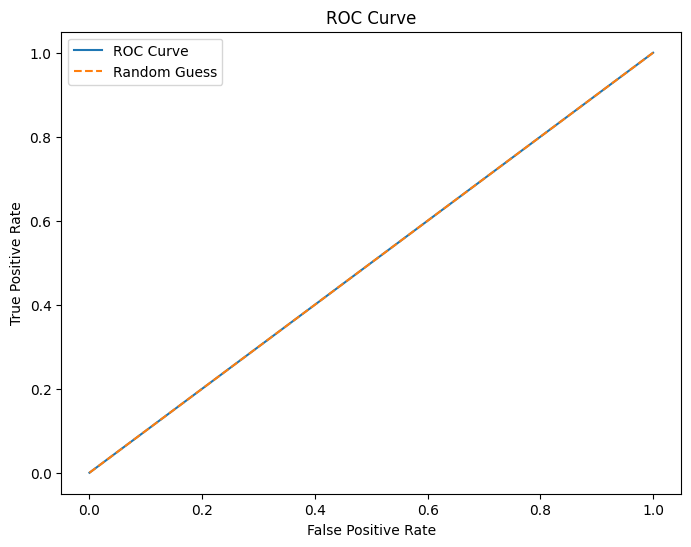

In [22]:
# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

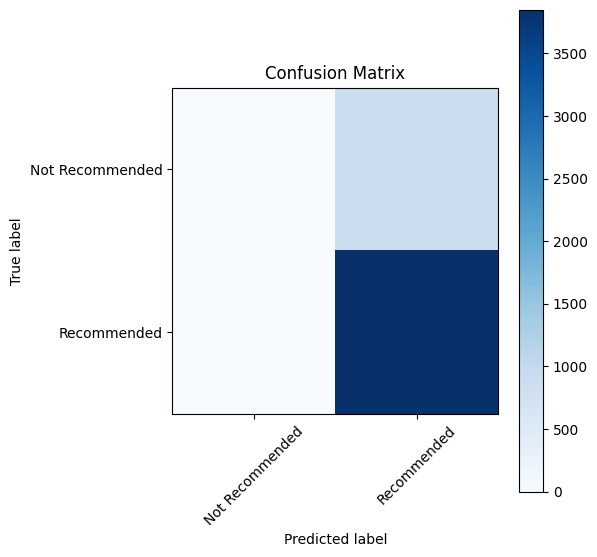

In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Not Recommended', 'Recommended'], rotation=45)
plt.yticks(np.arange(2), ['Not Recommended', 'Recommended'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


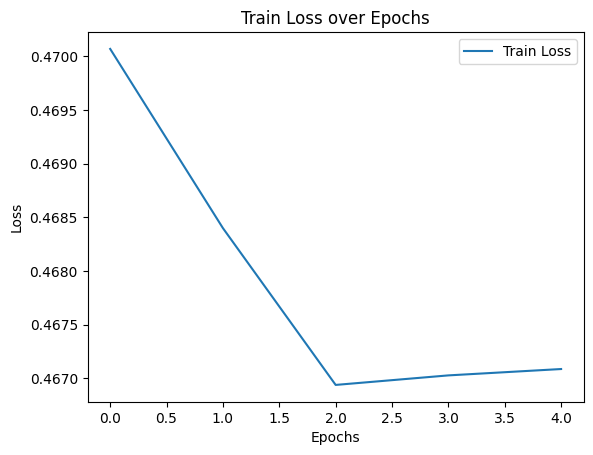

In [24]:
# Visualize the training loss over epochs
plt.plot(train_losses, label='Train Loss')
plt.title('Train Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.